# Оглавление
<a id="s1"></a>
[Описание проекта](#step1)  
[Знакомство с данными](#step2)  
[Приоритезация гипотез](#step3)  
[Анализ А/В-теста](#step4)  
[Рекомендации по результатам теста](#step5)  

# Описание проекта
<a id="step1"></a>
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

# Знакомство с данными
<a id="step2"></a>
Изучим предоставленные таблицы с гипотезами и результатами А/В-теста.

In [1]:
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
for i in [hypothesis, orders, visitors]:
    i.columns = i.columns.str.lower()
    display(i.head())
    i.info()
    print('full duplicates:', i.duplicated().sum())
    print('N/As:')
    print(i.isna().sum())
    print()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
full duplicates: 0
N/As:
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64



,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
full duplicates: 0
N/As:
transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
full duplicates: 0
N/As:
date        0
group       0
visitors    0
dtype: int64



Приведем в порядок типы данных и названия столбцов.

In [4]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
orders = orders.rename(columns={'transactionid': 'transaction_id', 'visitorid': 'visitor_id'})

Посмотрим, что за гипотезы выдвигают.

In [5]:
for i in range(len(hypothesis['hypothesis'])):
    print(i, hypothesis['hypothesis'][i])
    print()

0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

1 Запустить собственную службу доставки, что сократит срок доставки заказов

2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

3 Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар

4 Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей

5 Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов

6 Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

8 Запустить акцию, дающую скидку на товар в день рождения



**Вывод**  
Данные содержат информацию о выдвигаемых гипотезах, о заказах и посетителях во время проведения А/В-теста. Мы подготовили данные к дальнейшему анализу.

# Приоритизация гипотез
<a id="step3"></a>
Расставим гипотезам приоритеты по фреймворкам ICE и RICE.

In [6]:
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(1)
hypothesis['RICE'] = ((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(1)

Посмотрим, что получилось:

In [7]:
hypothesis.sort_values(by='ICE', ascending= False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2,112.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0,40.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0,56.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3,4.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0,3.0


In [8]:
hypothesis.sort_values(by='RICE', ascending= False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0,3.0


**Вывод**  
Добавление охвата к способу приоритезации изменило приоритеты гипотез. Например, гипотеза о добавлении формы подписки (гипотеза 7) имеет максимальный охват в 10 баллов, что увеличило приоритет в 10 раз и поставило эту гипотезу на первое место.

# Анализ A/B-теста
<a id="step4"></a>
Провели A/B-тест и получили результаты, которые описаны в файлах orders.csv и visitors.csv. Для начала узнаем, корректно ли были распределены посетители по группам: сравним количество в группах и проверим, попали ли одни и те же посетители в разные группы.

In [9]:
print('A:', orders.query('group == "A"')['visitor_id'].nunique())
print('B:', orders.query('group == "B"')['visitor_id'].nunique())

A: 503
B: 586


Довольно большая разница в количестве участников, группы в идеальном тесте должны быть равного размера.

In [10]:
groupA = orders.query('group == "A"')['visitor_id'].unique()
groupB = orders.query('group == "B"')['visitor_id'].unique()

count_doubles = 0
list_doubles = []
for visitor in groupB:
    if visitor in groupA:
        list_doubles.append(visitor)
        count_doubles += 1
        
print('Пользователей в обеих группах:', count_doubles)

Пользователей в обеих группах: 58


Процент пересечения групп не такой большой. Посмотрим на такие записи, чтобы выбрать стратегию их обработки.

In [11]:
for visitor in list_doubles:
    print(orders.query('visitor_id == @visitor'))

      transaction_id  visitor_id       date  revenue group
20        2904772834   963407295 2019-08-15      300     B
1183      1458356232   963407295 2019-08-14     4940     A
     transaction_id  visitor_id       date  revenue group
23       4252514150   351125977 2019-08-15    15185     B
453      3075639014   351125977 2019-08-06     4485     A
     transaction_id  visitor_id       date  revenue group
24       1162046357  3234906277 2019-08-15     7555     B
249      1360774578  3234906277 2019-08-18     7555     A
      transaction_id  visitor_id       date  revenue group
27        1630050528   237748145 2019-08-15     7620     B
41        2594268419   237748145 2019-08-15     1090     A
590       3702128013   237748145 2019-08-20     1290     A
716        972407388   237748145 2019-08-27      470     A
1097      3357467820   237748145 2019-08-12      340     A
     transaction_id  visitor_id       date  revenue group
32       3666913472  2038680547 2019-08-15     1680     B
117  

Пользователи, попавшие в обе группы, в основном, попадали в них в разные даты совершения заказа. Транзакции уникальны. К сожалению, мы ничего не знаем о проверяемой гипотезе. Возможно, такое разбиение корректно.

**Вывод**  
Удалить эти записи мы не можем, нет информации о гипотезе, процент таких записей не большой и уменьшится при очистке сырых данных далее. А также при удалении неккоректными окажутся данные из таблицы visitors с суммарным обезличенным количеством пользователей в ту или иную дату. К результатам теста отнесемся с осторожностью и сообщим о возможных проблемах в методике проведения теста. 

Построим график кумулятивной выручки по группам. Для начала получим данные для построения графика.

In [12]:
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [13]:
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


- И построим его:

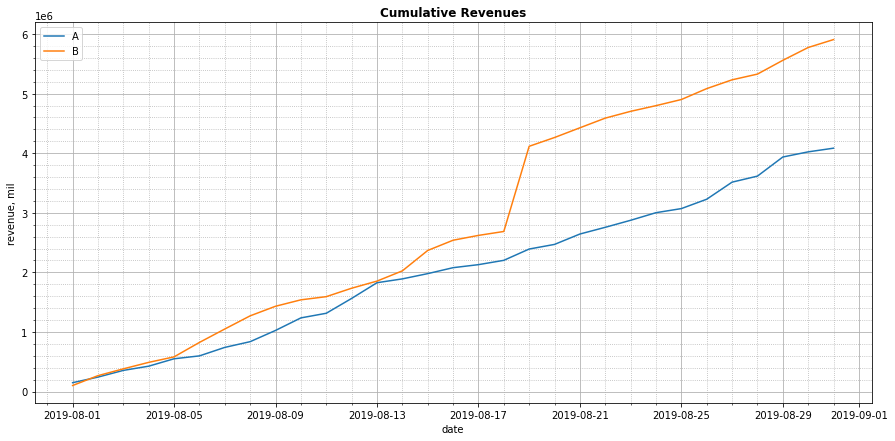

In [14]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,7))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title("Cumulative Revenues", fontweight="bold")
plt.xlabel("date")
plt.ylabel("revenue, mil")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.legend()
plt.show()

Кумулятивная выручка в группе В резко выросла за один день - 19 августа, а затем продолжила нарастать аналогично группе А. Посмотрим, что с заказами в этот день.

In [15]:
orders.query('date == "2019-08-19"').sort_values(by='revenue', ascending=False).head(5)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A
461,2683113224,154576532,2019-08-19,26550,B


In [16]:
orders['revenue'].median()

2978.0

Кто-то сделал огромный заказ в группе В - больше, чем на миллион - при медианном заказе в 3 тыс.

- Построим график кумулятивного среднего чека по группам.

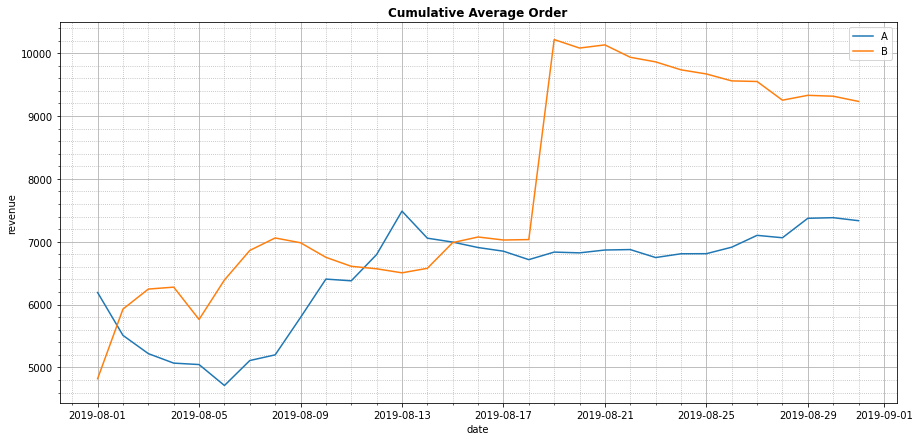

In [17]:
plt.figure(figsize=(15,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title("Cumulative Average Order", fontweight="bold")
plt.xlabel("date")
plt.ylabel("revenue")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.legend()
plt.show()

plt.show()

На графике снова аномалия 19 августа из-за того огромного заказа. Заменим этот заказ на медиану, чтобы посмотреть на результаты теста под более правильным ракурсом.

In [18]:
orders.loc[425, 'revenue'] = 3000

In [19]:
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

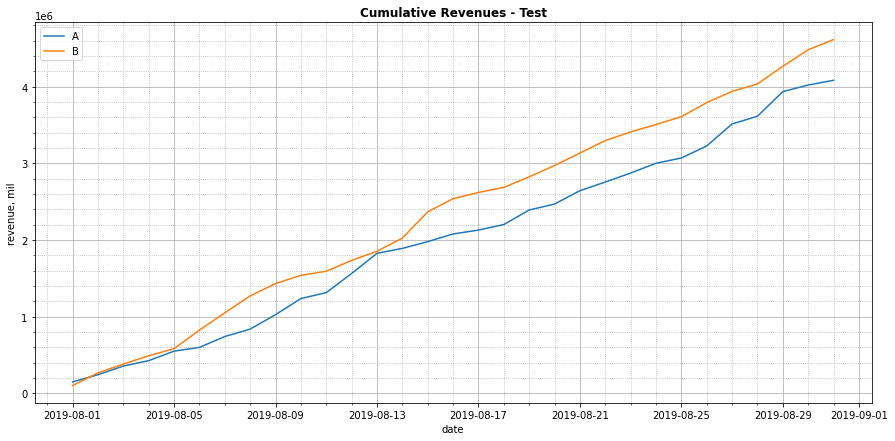

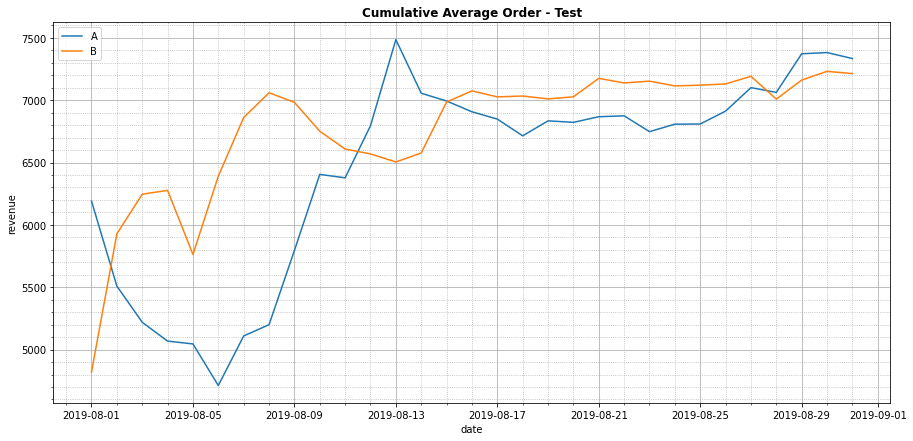

In [20]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,7))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title("Cumulative Revenues - Test", fontweight="bold")
plt.xlabel("date")
plt.ylabel("revenue, mil")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title("Cumulative Average Order - Test", fontweight="bold")
plt.xlabel("date")
plt.ylabel("revenue")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.legend()
plt.show()

plt.show()

В целом, группа В выглядит перспективно, поскольку выручка здесь больше. Вернем все как было, поскольку этого нет в задании. Будем идти по плану.

In [21]:
orders.loc[425, 'revenue'] = 1294500
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

- Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

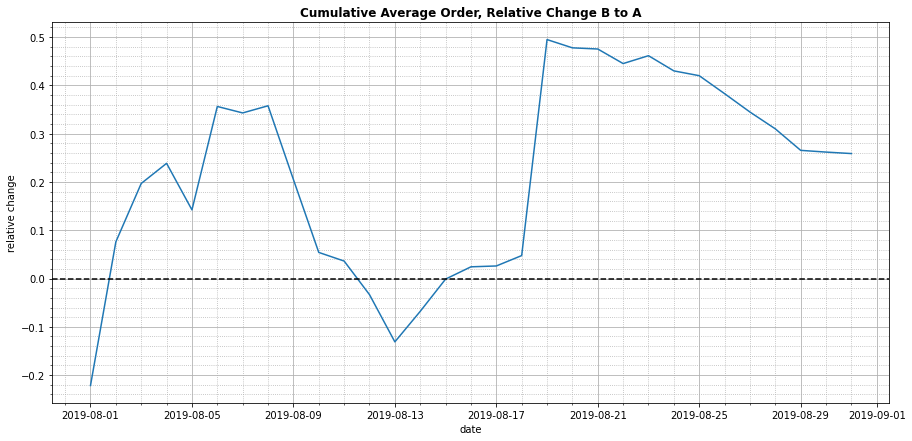

In [22]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,7))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')

plt.title("Cumulative Average Order, Relative Change B to A", fontweight="bold")
plt.xlabel("date")
plt.ylabel("relative change")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

plt.show()

Ожидаемо группа В сильно выросла того же 19 августа по среднему чеку.

- Построим график кумулятивной конверсии по группам.

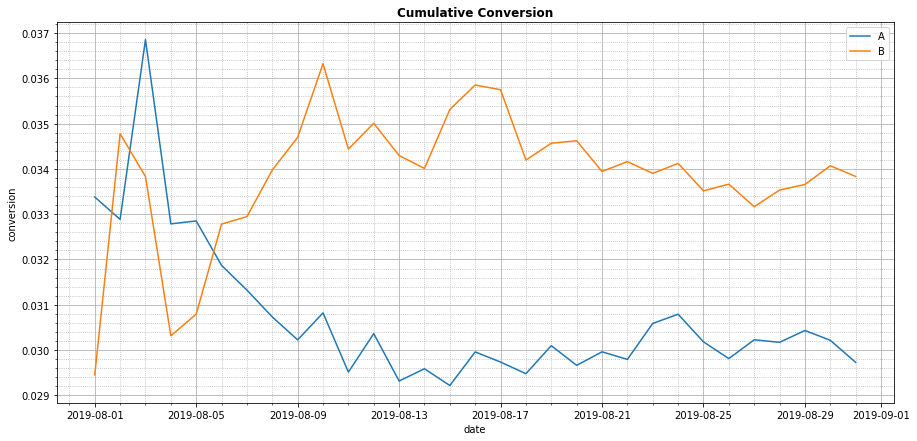

In [23]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(15,7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title("Cumulative Conversion", fontweight="bold")
plt.xlabel("date")
plt.ylabel("conversion")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.legend()
plt.show()

Кумулятивная конверсия в группе В стабильно выше.

- Построим график относительного изменения кумулятивной конверсии группы B к группе A.

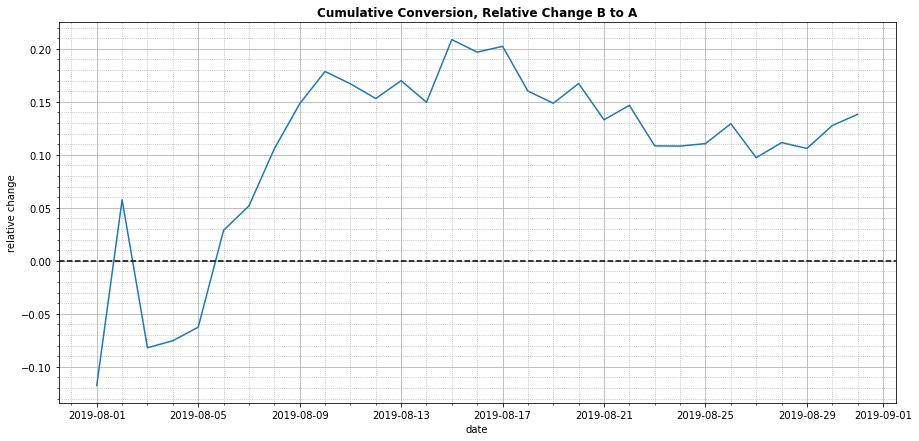

In [24]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,7))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Cumulative Conversion, Relative Change B to A", fontweight="bold")
plt.xlabel("date")
plt.ylabel("relative change")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

plt.show()


Кажется, конверсия в группе В примерно на 10% выше.

- Построим точечный график количества заказов по пользователям.

In [25]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


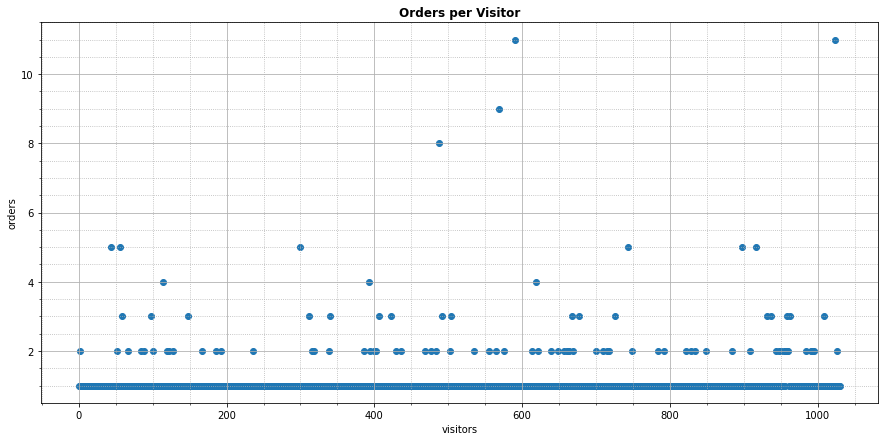

In [26]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15,7))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title("Orders per Visitor", fontweight="bold")
plt.xlabel("visitors")
plt.ylabel("orders")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

plt.show()

Абсолютное большинство делает 1 заказ, какая-то часть - 2.

- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [27]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Выберем границу для определения аномальных заказов = 3.

- Построим точечный график стоимости заказов.

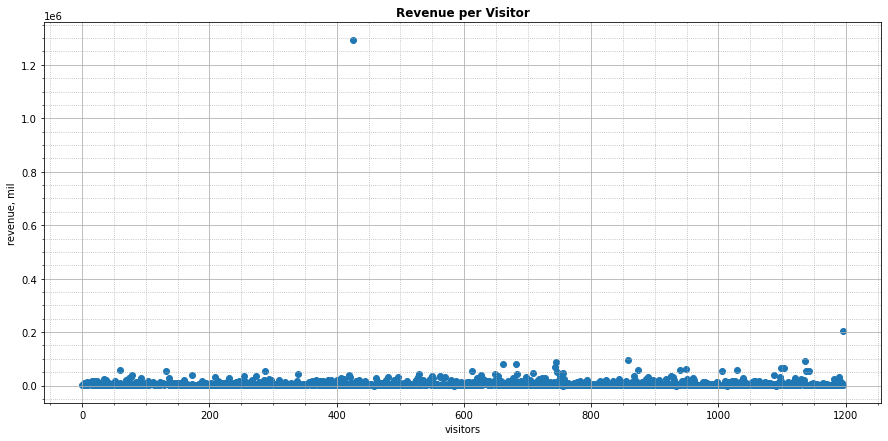

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,7))
plt.scatter(x_values, orders['revenue'])
plt.title("Revenue per Visitor", fontweight="bold")
plt.xlabel("visitors")
plt.ylabel("revenue, mil")
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

plt.show()

На графике видно, что большинство заказов меньше 25 тыс.

- Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [29]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Выберем границу в 40 тыс.

- Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Для этого расчитаем критерий Манна — Уитни. Сформулируем нулевую гипотезу о том, что значимых различий в конверсии между группами нет. Альтернативную - есть значимые различия. Уровень статистической значимости примем за 0.05.


In [30]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))



p-value: 0.017


Отвергаем нулевую гипотезу о том, что статистически значимого различия нет.

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Для этого расчитаем критерий Манна — Уитни. Сформулируем нулевую гипотезу о том, что значимых различий в среднем чеке между группами нет. Альтернативную - есть значимые различия. Уровень статистической значимости примем за 0.05.

In [31]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

p-value: 0.729


P-value значительно больше 0.05. Остаемся с нулевой гипотезой о том, что различий в среднем чеке нет.

- Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

In [32]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
18      199603092
23      237748145
684     358944393
648     382846391
Name: visitor_id, dtype: int64
(34,)


34 аномальных пользователя. Очистим от них данные.

In [33]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

p-value: 0.009


Ничего особо не изменилось.

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [34]:
print('p-value:', 
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

p-value: 0.711


Очистка здесь так же не повлияла на результаты.

# Рекомендации по результатам теста
<a id="step5"></a>
Результаты теста показали повышенную конверсию и выручку в группе В. По среднему чеку статистически значимого различия нет. 
Данные стабилизировались в обоих случаях (я показал это на графике без той уникальной миллионной аномалии). Рекомендуем закончить тест и признать его успешным с оговоркой о том, что методика проведения теста может быть не совсем верной, поскольку встречаются пользователи, попавшие в обе группы.

[В начало](#s1)